# SubBeamNod Data Reduction
---------------------------

SubBeamNod data, where a single pixel in a pixel 
camera is used to do a beam nod, is retrieved 
using `gbtfitsload.GBTFITSLoad.subbeamnod` which returns a `Spectrum` object. 
First, import the relevant module:

In [1]:
from dysh.fits.gbtfitsload import GBTFITSLoad

Then load your SDFITS file containing SubBeamNod data. In this example, we use a GBT SDFITS file downloadable from GBO http://www.gb.nrao.edu/dysh/example_datasubbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits

In [2]:
f = 'TRCO_230413_Ka.raw.vegas.A.fits'
sdfits = GBTFITSLoad(f)

The returned `sdfits` can be probed for information.
You can also print a concise (or verbose if you choose verbose=True) summary of the data.

In [3]:
sdfits.info()
sdfits.summary()


Filename: TRCO_230413_Ka.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   5280R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '1024E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,32.0,1256-0547,0.0,Nod,1.0,26.5,26.5,1,2,60,2,160.975324,43.884984
1,33.0,1256-0547,0.0,Nod,2.0,26.5,26.5,1,2,60,2,161.174093,43.928449
2,34.0,1256-0547,0.0,Nod,1.0,30.5,30.5,1,2,60,2,161.589629,44.000491
3,35.0,1256-0547,0.0,Nod,2.0,30.5,30.5,1,2,60,2,161.783395,44.041622
4,36.0,1256-0547,0.0,Unknown,0.0,0.75,0.75,1,2,120,2,162.124052,44.100404
5,37.0,1256-0547,0.0,Nod,1.0,34.5,34.5,1,2,60,2,162.611075,44.183661
6,38.0,1256-0547,0.0,Nod,2.0,34.5,34.5,1,2,60,2,162.896506,44.237997
7,39.0,1256-0547,0.0,Nod,1.0,37.5,37.5,1,2,60,2,163.333508,44.306385
8,40.0,1256-0547,0.0,Nod,2.0,37.5,37.5,1,2,60,2,163.529285,44.343704
9,41.0,1256-0547,0.0,Nod,1.0,30.5,30.5,1,2,60,2,164.941425,44.559629


The SubBeamNod scans are 43, 46, and 54. Retrieve and calibrate a
SubBeamNod scan, then plot it:

In [4]:
w='tsys'

GROUPS  [array([2883, 2887, 2891, 2895, 2899, 2903, 2907, 2911, 2915, 2919, 2923]), array([2991, 2995, 2999, 3003, 3007, 3011, 3015, 3019]), array([3083, 3087, 3091, 3095, 3099, 3103, 3107, 3111, 3115]), array([3179, 3183, 3187, 3191, 3195, 3199, 3203, 3207, 3211]), array([3275, 3279, 3283, 3287, 3291, 3295, 3299, 3303, 3307])] [array([2935, 2939, 2943, 2947, 2951, 2955, 2959, 2963, 2967, 2971]), array([3031, 3035, 3039, 3043, 3047, 3051, 3055, 3059, 3063, 3067]), array([3131, 3135, 3139, 3143, 3147, 3151, 3155, 3159, 3163]), array([3227, 3231, 3235, 3239, 3243, 3247, 3251, 3255, 3259]), array([3323, 3327, 3331, 3335, 3339, 3343, 3347, 3351, 3355, 3359])] [array([2882, 2886, 2890, 2894, 2898, 2902, 2906, 2910, 2914, 2918, 2922]), array([2990, 2994, 2998, 3002, 3006, 3010, 3014, 3018]), array([3082, 3086, 3090, 3094, 3098, 3102, 3106, 3110, 3114]), array([3178, 3182, 3186, 3190, 3194, 3198, 3202, 3206, 3210]), array([3274, 3278, 3282, 3286, 3290, 3294, 3298, 3302, 3306])] [array([2934, 

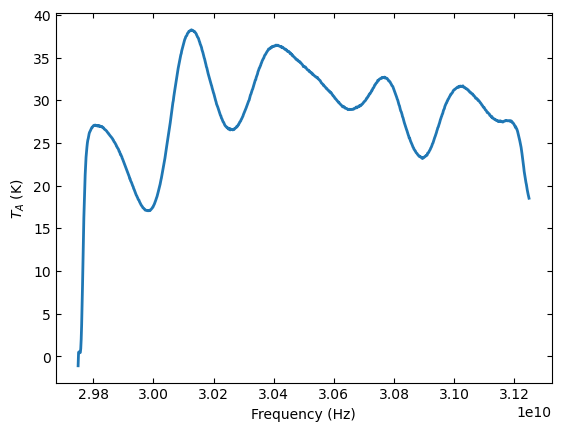

In [5]:
sbnk = sdfits.subbeamnod(scan=43,fdnum=1,ifnum=0,weights='tsys')
sbnk.plot()

GROUPS  [array([2883, 2887, 2891, 2895, 2899, 2903, 2907, 2911, 2915, 2919, 2923]), array([2991, 2995, 2999, 3003, 3007, 3011, 3015, 3019]), array([3083, 3087, 3091, 3095, 3099, 3103, 3107, 3111, 3115]), array([3179, 3183, 3187, 3191, 3195, 3199, 3203, 3207, 3211]), array([3275, 3279, 3283, 3287, 3291, 3295, 3299, 3303, 3307])] [array([2935, 2939, 2943, 2947, 2951, 2955, 2959, 2963, 2967, 2971]), array([3031, 3035, 3039, 3043, 3047, 3051, 3055, 3059, 3063, 3067]), array([3131, 3135, 3139, 3143, 3147, 3151, 3155, 3159, 3163]), array([3227, 3231, 3235, 3239, 3243, 3247, 3251, 3255, 3259]), array([3323, 3327, 3331, 3335, 3339, 3343, 3347, 3351, 3355, 3359])] [array([2882, 2886, 2890, 2894, 2898, 2902, 2906, 2910, 2914, 2918, 2922]), array([2990, 2994, 2998, 3002, 3006, 3010, 3014, 3018]), array([3082, 3086, 3090, 3094, 3098, 3102, 3106, 3110, 3114]), array([3178, 3182, 3186, 3190, 3194, 3198, 3202, 3206, 3210]), array([3274, 3278, 3282, 3286, 3290, 3294, 3298, 3302, 3306])] [array([2934, 

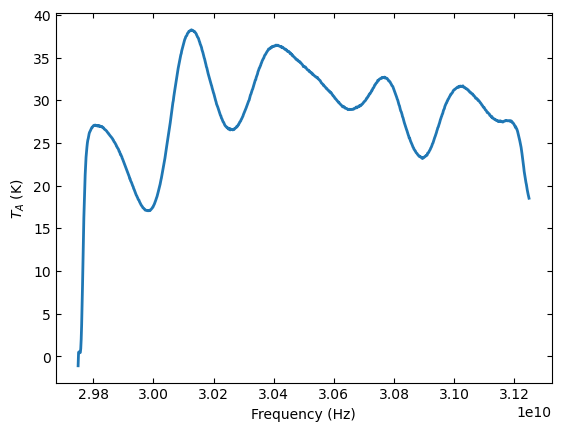

In [6]:
sbn = sdfits.subbeamnod(scan=43,fdnum=1,ifnum=0,weights=w)
sbn.plot()

In [7]:
sbn.data - sbnk.data

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
sbn2 = sdfits.subbeamnod2(scan=43,fdnum=1,ifnum=0,weights=w)

GROUPS  [array([2883, 2887, 2891, 2895, 2899, 2903, 2907, 2911, 2915, 2919, 2923]), array([2991, 2995, 2999, 3003, 3007, 3011, 3015, 3019]), array([3083, 3087, 3091, 3095, 3099, 3103, 3107, 3111, 3115]), array([3179, 3183, 3187, 3191, 3195, 3199, 3203, 3207, 3211]), array([3275, 3279, 3283, 3287, 3291, 3295, 3299, 3303, 3307])] [array([2935, 2939, 2943, 2947, 2951, 2955, 2959, 2963, 2967, 2971]), array([3031, 3035, 3039, 3043, 3047, 3051, 3055, 3059, 3063, 3067]), array([3131, 3135, 3139, 3143, 3147, 3151, 3155, 3159, 3163]), array([3227, 3231, 3235, 3239, 3243, 3247, 3251, 3255, 3259]), array([3323, 3327, 3331, 3335, 3339, 3343, 3347, 3351, 3355, 3359])] [array([2882, 2886, 2890, 2894, 2898, 2902, 2906, 2910, 2914, 2918, 2922]), array([2990, 2994, 2998, 3002, 3006, 3010, 3014, 3018]), array([3082, 3086, 3090, 3094, 3098, 3102, 3106, 3110, 3114]), array([3178, 3182, 3186, 3190, 3194, 3198, 3202, 3206, 3210]), array([3274, 3278, 3282, 3286, 3290, 3294, 3298, 3302, 3306])] [array([2934, 

In [9]:
sbn2[0].calibrated(0)

<Spectrum1D(flux=<Quantity [ 1.29341831,  0.57197488,  0.54756602, ..., 20.17125875,
           19.92924671, 19.69146751] K>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0
    doppler_rest=30500000000.0 Hz
    doppler_convention=radio)
  [2.97500000e+10, 2.97514648e+10, 2.97529297e+10, ..., 3.12456055e+10,
   3.12470703e+10, 3.12485352e+10] Hz>)>

NCHAN  1024


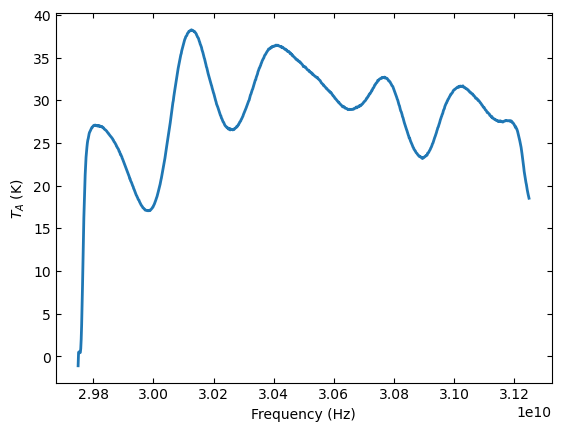

In [10]:
sbn2.timeaverage()[0].plot()

In [11]:
data2 = sbn2.timeaverage(weights='tsys')[0].data
data1 = sbn.data
data3 = sbn2.timeaverage()[0].data

NCHAN  1024
NCHAN  1024


In [12]:
data1 - data2

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
data1

array([-1.0972615 ,  0.46332444,  0.5356332 , ..., 18.97662869,
       18.75325767, 18.52688884])

In [14]:
data2

array([-1.0972615 ,  0.46332444,  0.5356332 , ..., 18.97662869,
       18.75325767, 18.52688884])

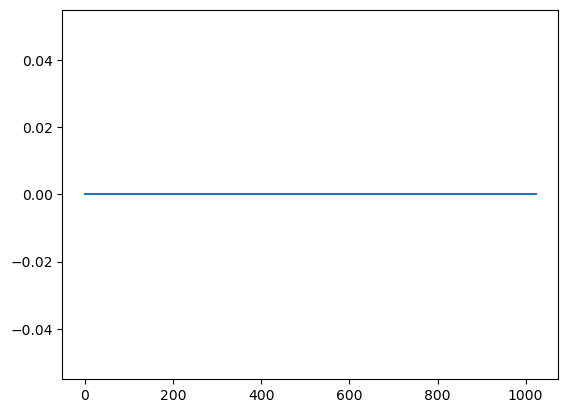

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots()
ax.plot(np.arange(len(data1)),data1 - data2)

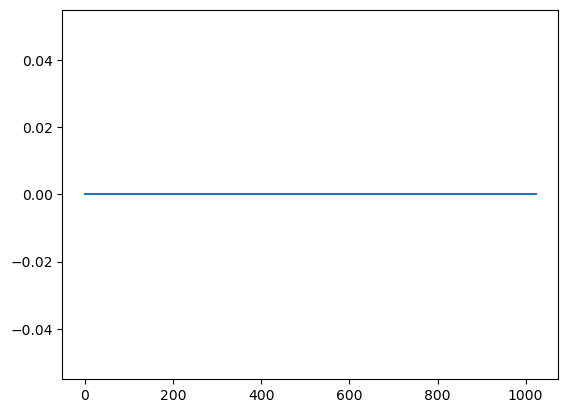

In [16]:
fig,ax = plt.subplots()
ax.plot(np.arange(len(data1)),data1 - data3)

In [17]:
(data1 - data3) == (data1 - data2)

array([ True,  True,  True, ...,  True,  True,  True])

In [18]:
tadiff = sbn2[0]._timeaveraged._data - sbn2[0]._timeaveraged2._data

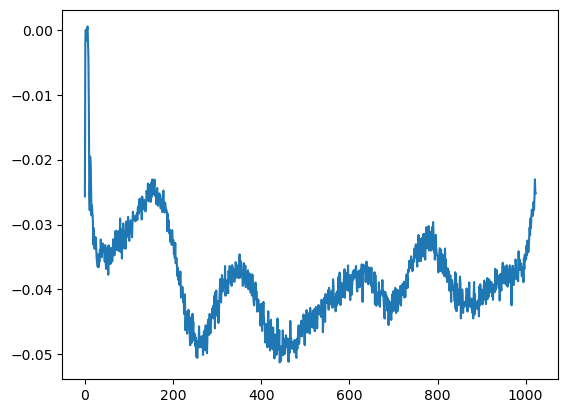

In [19]:
fig,ax = plt.subplots()
ax.plot(np.arange(len(tadiff)),tadiff)

In [20]:
sbn2[0].tavg2

array([-1.0972615 ,  0.46332444,  0.5356332 , ..., 18.97662869,
       18.75325767, 18.52688884], dtype=float128)

In [21]:
sbn2[0]._timeaveraged.data

array([-1.0972615 ,  0.46332444,  0.5356332 , ..., 18.97662869,
       18.75325767, 18.52688884])

In [22]:
sbn2[0]._timeaveraged2.data

array([-1.07158761,  0.46514546,  0.53562311, ..., 18.99965839,
       18.7783763 , 18.55206856], dtype=float128)

In [27]:
tadiff=sbn2[0]._timeaveraged2.data-sbn2[0].tavg2

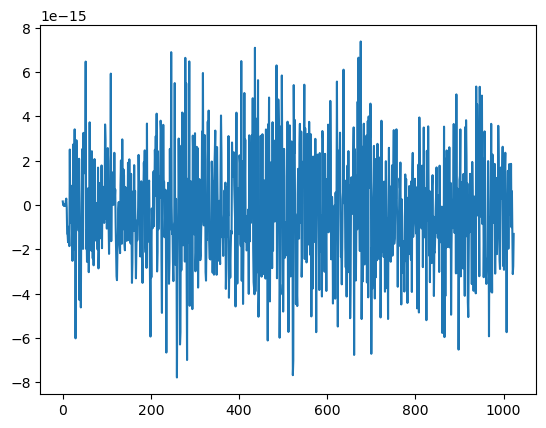

In [25]:
fig,ax = plt.subplots()
ax.plot(np.arange(len(tadiff)),tadiff)
#ax.set_ylim(-.025,0)

In [28]:
tadiff

array([ 2.56738901e-02,  1.82102124e-03, -1.00870067e-05, ...,
        2.30297070e-02,  2.51186280e-02,  2.51797155e-02], dtype=float128)